# 0. Imports and settings

In [1]:
# Load libraries
print("Loading libraries")
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import KDTree
from scipy import stats
import mplhep
from collections import namedtuple
print("Libraries loaded")

# Set mpl settings
plt.style.use(mplhep.style.CMS)
print("CMS MPL style set")

Loading libraries
Libraries loaded
CMS MPL style set


# 1. Global classes and functions

In [2]:
def readData(path, printBranches=False):
    data = uproot.open(path)['Events']
    
    if printBranches:
        for branch in data:
            print(branch)
        return data
    else:
        return data

In [4]:
class Candidates:

    def __init__(self, data):
        puppi_pt = data["l1tLayer2DeregionizerCands_pt"].array()
        puppi_pt_sort = ak.argsort(puppi_pt)
        self.pt = puppi_pt[puppi_pt_sort]
        self.eta = data["l1tLayer2DeregionizerCands_eta"].array()
        self.phi = data["l1tLayer2DeregionizerCands_phi"].array()

In [5]:
class Jet:
    """
    Takes init args data, branch, colour and marker
    """
    class Seeds:
        def __init__(self, data, branch):
            self.pt = data[branch+"Jets_dau0_pt"].array()
            self.eta = data[branch+"Jets_dau0_eta"].array()
            self.phi = data[branch+"Jets_dau0_phi"].array()

    def __init__(self, data, branch, colour, marker):
        self.name = branch
        self.colour = colour
        self.marker = marker
        
        self.pt = data[branch+"Jets_pt"].array()
        self.eta = data[branch+"Jets_eta"].array()
        self.phi = data[branch+"Jets_phi"].array()

        self.seeds = self.Seeds(data=data, branch=branch)

    def changeColour(self, newColour):
        self.colour = newColour
    def changeMarker(self, newMarker):
        self.marker = newMarker

In [ ]:
class Plot:
    fig, ax = plt.subplots(figsize=(12, 12))

    def __init__(self, event, candidates):
        self.cands = candidates
        self.event = event
        self.jetsPlotted = []
        

    def plotCands(self):
        event, candidates = self.event, self.cands

        self.ax.scatter(candidates.eta[event], candidates.phi[event], c=np.log(candidates.pt[event]), cmap="Greys", label="PUPPI Candidates")    # Plot PUPPI candidates
        
        self.ax.set_xlabel('η')    # Set x and y labels
        self.ax.set_ylabel('ϕ')    #
        self.ax.set_ylim((-np.pi, np.pi))
        self.ax.set_xlim((-5, 5))
        self.ax.set_aspect('equal', 'box')
        self.ax.set_title("Level 1 jets. Event = {}".format(event))
        #mplhep.cms.label(label="Preliminary. Jet classification by three different algorithms. Event = {}".format(Ev), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
        self.ax.legend()
        plt.show()

In [76]:
class Plot:

    def __init__(self, event, candidates):
        self.cands = candidates
        self.event = event
        self.jetsPlotted = []
        self.fig, self.ax = None, None

    def plotCands(self):
        event, candidates = self.event, self.cands
        self.fig, self.ax = plt.subplots(figsize=(12, 12))

        self.ax.scatter(candidates.eta[event], candidates.phi[event], c=np.log(candidates.pt[event]), cmap="Greys", label="PUPPI Candidates")    # Plot PUPPI candidates
        
        self.ax.set_xlabel('η')    # Set x and y labels
        self.ax.set_ylabel('ϕ')    #
        self.ax.set_ylim((-np.pi, np.pi))
        self.ax.set_xlim((-5, 5))
        self.ax.set_aspect('equal', 'box')
        self.ax.set_title("Level 1 jets. Event = {}".format(event))
        #mplhep.cms.label(label="Preliminary. Jet classification by three different algorithms. Event = {}".format(Ev), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
        self.ax.legend()
        plt.show()

    def addJets(self, jets, r=0.8, jetCap=16, circleOnSeed=True):
        event = self.event
        for jetType in jets:    # Iterate over the different types of jets
            self.jetsPlotted.append(jetType.name)
            eta, phi, pt = jetType.eta[event][:jetCap], jetType.phi[event][:jetCap], jetType.pt[event][:jetCap]
            seed_eta, seed_phi, seed_pt = jetType.seeds.eta[event], jetType.seeds.phi[event], jetType.seeds.pt[event]
            name, mark, col = jetType.name, jetType.marker, jetType.colour
            
            self.ax.scatter(eta, phi, s=30*np.log(pt), label=name, marker=mark, edgecolors=col, facecolor='none')    # Plot the jets up to the jet cap
            for i, _ in enumerate(pt):    # Iterate over the jets
                if circleOnSeed!=True:
                    self.ax.add_patch(plt.Circle((eta[i], phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))    # Add circle around given jet to the current axis
                    if phi[i] + r > np.pi:
                        self.ax.add_patch(plt.Circle((eta[i], -2*np.pi+phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
                    if phi[i] - r < -np.pi:
                        self.ax.add_patch(plt.Circle((eta[i], 2*np.pi+phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))

                else:    # Places the circle around the seed
                    self.ax.add_patch(plt.Circle((seed_eta[i], seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--" ))    # Add circle around given jet to the current axis
                    """ Phi wrapping """
                    if seed_phi[i] + r > np.pi:
                        self.ax.add_patch(plt.Circle((seed_eta[i], -2*np.pi+seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
                    if seed_phi[i] - r < -np.pi:
                        self.ax.add_patch(plt.Circle((seed_eta[i], 2*np.pi+seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))

    def show(self):
        plt.show(self.ax)

In [7]:
cands = Candidates(data=dat)

In [8]:
sc = Jet(data=dat, branch="scPuppi", marker="X", colour="red")

In [77]:
event0 = Plot(event=0, candidates=cands)

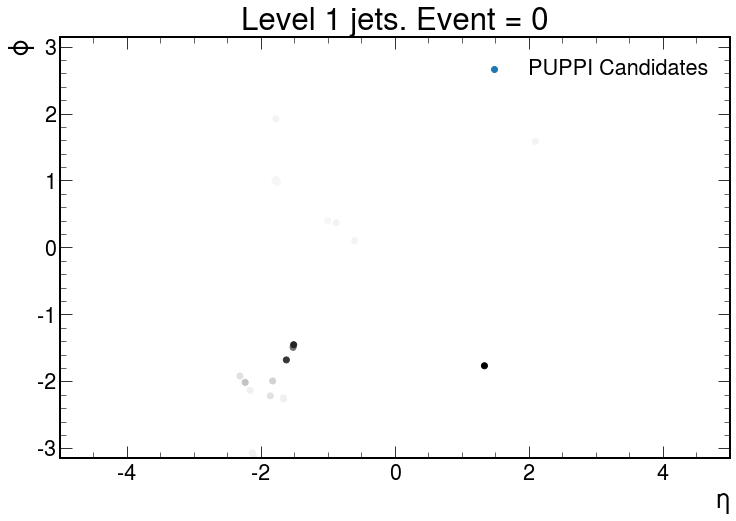

In [78]:
event0.plotCands()

In [79]:
event0.show()

In [6]:
def jetConstructor(data, jetParams):
    jets = []
    for jet in jetParams:
        print("Loading {}".format(jet))
        jets.append(Jet(data, jet, *jetParams[jet]))
    
    return jets

# 2. Plotting functions

In [18]:
cands = Candidates(data=dat)

In [5]:
def jetPlotter(Ev, jets, jetCap, r=0.4, jetCircle=False):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.scatter(cands.eta[Ev], cands.phi[Ev], c=np.log(cands.pt[Ev]), cmap="Greys", label="PUPPI Candidates")    # Plot PUPPI candidates
    
    for jetType in jets:    # Iterate over the different types of jets
        eta, phi, pt = jetType.eta[Ev][:jetCap], jetType.phi[Ev][:jetCap], jetType.pt[Ev][:jetCap]
        seed_eta, seed_phi, seed_pt = jetType.seeds.eta[Ev], jetType.seeds.phi[Ev], jetType.seeds.pt[Ev]
        name, mark, col = jetType.name, jetType.marker, jetType.colour
        
        ax.scatter(eta, phi, s=30*np.log(pt), label=name, marker=mark, edgecolors=col, facecolor='none')    # Plot the jets up to the jet cap
        for i, _ in enumerate(pt):    # Iterate over the jets
            if jetCircle:
                ax.add_patch(plt.Circle((eta[i], phi[i]), r, edgecolor=jetType.colour, facecolor='none', linewidth=1, linestyle="--"))    # Add circle around given jet to the current axis
                if phi[i] + r > np.pi:
                    ax.add_patch(plt.Circle((eta[i], -2*np.pi+phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
                if phi[i] - r < -np.pi:
                    ax.add_patch(plt.Circle((eta[i], 2*np.pi+phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
    
            else:    # Places the circle around the seed
                ax.add_patch(plt.Circle((seed_eta[i], seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--" ))    # Add circle around given jet to the current axis
                """ Phi wrapping """
                if seed_phi[i] + r > np.pi:
                    ax.add_patch(plt.Circle((seed_eta[i], -2*np.pi+seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
                if seed_phi[i] - r < -np.pi:
                    ax.add_patch(plt.Circle((seed_eta[i], 2*np.pi+seed_phi[i]), r, edgecolor=col, facecolor='none', linewidth=1, linestyle="--"))
    
    
    ax.set_xlabel('η')    # Set x and y labels
    ax.set_ylabel('ϕ')    #
    ax.set_ylim((-np.pi, np.pi))
    ax.set_xlim((-5, 5))
    ax.set_aspect('equal', 'box')
    ax.set_title("Level 1 jets. Event = {}".format(Ev))
    #mplhep.cms.label(label="Preliminary. Jet classification by three different algorithms. Event = {}".format(Ev), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    ax.legend()
    return ax

# 3. Wide cone Jets

In [38]:
ntuple = "~/cernbox/wideCone/wideConeSig.root"
sig = readData(ntuple, printBranches=True)

<TBranch 'run' at 0x7f9a405c69b0>
<TBranch 'luminosityBlock' at 0x7f9a405c65f8>
<TBranch 'event' at 0x7f9a405a0dd8>
<TBranch 'bunchCrossing' at 0x7f9a405544e0>
<TBranch 'nL1PFCands' at 0x7f9a40554ac8>
<TBranch 'L1PFCands_pt' at 0x7f9a405580f0>
<TBranch 'L1PFCands_eta' at 0x7f9a405586d8>
<TBranch 'L1PFCands_phi' at 0x7f9a40558cc0>
<TBranch 'L1PFCands_mass' at 0x7f9a4055f2e8>
<TBranch 'L1PFCands_charge' at 0x7f9a4055f8d0>
<TBranch 'L1PFCands_pdgId' at 0x7f9a4055fef0>
<TBranch 'L1PFCands_puppiWeight' at 0x7f9a40567550>
<TBranch 'nL1PuppiCands' at 0x7f9a40567b38>
<TBranch 'L1PuppiCands_pt' at 0x7f9a4056e160>
<TBranch 'L1PuppiCands_eta' at 0x7f9a4056e748>
<TBranch 'L1PuppiCands_phi' at 0x7f9a4056ed30>
<TBranch 'L1PuppiCands_mass' at 0x7f9a40576358>
<TBranch 'L1PuppiCands_charge' at 0x7f9a40576940>
<TBranch 'L1PuppiCands_pdgId' at 0x7f9a40576f60>
<TBranch 'L1PuppiCands_puppiWeight' at 0x7f9a4057c5c0>
<TBranch 'nl1tLayer2DeregionizerCands' at 0x7f9a4057cba8>
<TBranch 'l1tLayer2DeregionizerCan

In [9]:
cands = Candidates(data=sig)

In [10]:
jetParams = {
    "wideHSC" : ("red", "^"),
    "scPuppi" : ("blue", "X")
}

wideHSC, sc = jetConstructor(data=sig, jetParams=jetParams)

Loading wideHSC
Loading scPuppi


<AxesSubplot:title={'center':'Level 1 jets. Event = 1'}, xlabel='η', ylabel='ϕ'>

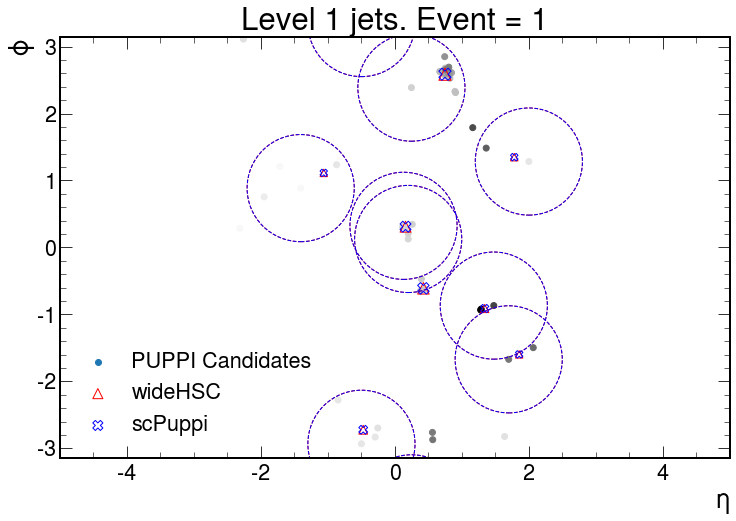

In [37]:
jetPlotter(Ev=1, jets=[wideHSC, sc], jetCap=50, r=0.8, jetCircle=False)

# 4. Regular Jets

In [ ]:
path = "~/cernbox/outputFiles/seedSize/TTbar/TTbarTrimmed.root"
data = uproot.open(path)['Events']

## Histogrammer illustrator

In [ ]:
ev=7
cap=5
fig, ax = plt.subplots(figsize=(12, 12))
#fig, ax = plt.subplots()
ax.hist2d(
    cands["eta"][ev], cands["phi"][ev],
    weights=np.log(cands["pt"][ev]),
    bins=50,
    cmap="Reds"
#    range=[ (-5, 5), (-np.pi, np.pi) ]
)

def Square(ax):
    ax.add_patch(plt.Rectangle((0,0), 10, 10))
    
ax.add_patch(plt.Rectangle((-0.5, -2.1), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle((-0.5, -2.35), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle((-0.5, -2.6), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))

ax.add_patch(plt.Rectangle( (-0.75, -2.1), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-0.75, -2.35), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-0.75, -2.6), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))

ax.add_patch(plt.Rectangle( (-1.0, -2.10), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-1.0, -2.35), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
ax.add_patch(plt.Rectangle( (-1.0, -2.6), 0.25, 0.25, edgecolor="r", facecolor='none', linewidth=1, linestyle="-"))
    
#ax.set_title("Phase 1 Histogrammer")
mplhep.cms.label(label="Phase 1 histogrammer".format(), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
ax.set_xlabel("η\eta"); ax.set_ylabel("ϕ\phi")

ax.scatter(gen["eta"][ev][:cap], gen["phi"][ev][:cap], s=30*np.log(gen["pt"][ev][:cap]), marker="X", edgecolors="black", facecolor='none', label="Generator jets")
ax.set_xlabel('η\eta')    # Set x and y labels
ax.set_ylabel('ϕ\phi')    #
ax.set_ylim((-np.pi, np.pi))
ax.set_xlim((-5, 5))
ax.set_aspect('equal', 'box')
ax.legend()
plt.show()

## Cutting jets on pT

In [ ]:
def ptCutter(jetDict, cut=25):
    filtArray = jetDict["pt"][:] > cut
    jetDict["pt"] = jetDict["pt"][:][filtArray]
    jetDict["eta"] = jetDict["eta"][:][filtArray]
    jetDict["phi"] = jetDict["phi"][:][filtArray]
    return jetDict

In [ ]:
sc_cut = ptCutter(sc)
hsc_cut = ptCutter(hsc)
hist_cut = ptCutter(hist)

## Plotting the jets

In [ ]:
plotter([one, gen], jetCap=8, Ev=1000, jetCircle=True)

## Generating data

In [ ]:
def seedAxisDiff(jetType, allEvs=True, distThresh=5):

    jetTypeNEW = jetType
    anoms = []
    nEvents = len(jetTypeNEW["pt"]) if allEvs == True else allEvs
    for ev in range(nEvents):
        jetEta = jetTypeNEW["eta"][ev]
        seedEta = jetTypeNEW["seeds"]["eta"][ev]

        jetPhi = jetTypeNEW["phi"][ev]
        seedPhi = jetTypeNEW["seeds"]["phi"][ev]
        
        distances = ((jetEta - seedEta)**2 + (jetPhi - seedPhi)**2)**0.5
        # distancesTruthTable = distances > distThresh
        # passedJetsIdx = [idx for idx, logic in enumerate(distancesTruthTable) if logic]
        # passedDistances = distances[distancesTruthTable]
        
        # for dist in passedJetsIdx:
        anoms.append(distances > distThresh)
        #anoms = np.append(anoms, [distances > distThresh], axis=0)
            #jetType["seeds"]["anom"].append(distances > distThresh)

    jetTypeNEW["seeds"]["anom"] = anoms
    
    return jetTypeNEW

In [ ]:
hsc

In [ ]:
hsc2 = seedAxisDiff(hsc, allEvs = 100, distThresh=0.2)

In [ ]:
hsc2["seeds"]["anom"]

In [ ]:
plotter([gen, hsc, nine], Ev=1034, jetCap=8, jetCircle=False)

In [ ]:
def pairer(gen, jet, ev, r=0.4):
    """
    - Get a KDTree containing every sc jet
    - In a loop over every gen jet, query the tree with the gen jet
    - This will return the nearest sc jet to the gen jet
    """

    res = {
        "genXY"     : [],
        "jetXY"     : [],
        "seedXY"    : [],
        "dist"      : [],
        "eta_dist"  : [],
        "phi_dist"  : [],
        "pt"        : [],
        "unpaired"  : 0,
        "totalJets" : 0
    }
    
    jetXY, jetPt = list( zip(jet["seeds"]["eta"][ev], jet["seeds"]["phi"][ev]) ), jet["pt"][ev]
    genXY, genPt = list( zip(gen["eta"][ev], gen["phi"][ev]) ), gen["pt"][ev]
    if len(jetXY) == 0:
        res["unpaired"] = len(genPt)
        res["genXY"] = genXY
        return res
    
    jetKDT = KDTree(jetXY)
    for idx, genJet in enumerate(genXY):
        res["totalJets"] += 1
        dist, order = jetKDT.query(genJet)
        if dist < r:
            res["genXY"].append(genJet)
            res["jetXY"].append(jetXY[order])
            res["dist"].append(dist)
            res["pt"].append((genPt[idx] - jetPt[order]) / genPt[idx])
            res["eta_dist"].append(genJet[0] - jetXY[order][0])
            res["phi_dist"].append(genJet[1] - jetXY[order][1])
        else:
            res["unpaired"] += 1

    return res

In [ ]:
def datCalc(jetAlgos, quant, gen=gen, events=len(gen["pt"])):
    assert quant in ["dist", "pt", "unpaired", "totalJets", "eta_dist", "phi_dist"]
    
    if quant == "unpaired" or quant == "totalJets":
        dic = {algo["name"]:0 for algo in jetAlgos}
    else:
        dic = {algo["name"]:[] for algo in jetAlgos}
    
    for algo in jetAlgos:
        for event in range(events):
            dat = pairer(gen=gen, jet=algo, ev=event)
            dic[algo["name"]] += dat[quant]

    return dic

In [ ]:
pts = datCalc([hsc, three, five, seven, nine], quant="pt", events=10000)

In [ ]:
histPlotter(pts)

In [ ]:
dists = datCalc([hsc, three, five, seven, nine], quant="dist", events=10000)

In [ ]:
dists

In [ ]:
for i in dists:
    print(i)

In [ ]:
def histPlotter(var):

    binning=np.linspace(-0.4, 0.4, 100)
    for i in var:
        plt.hist(
            var[i],
            bins=binning,
            histtype="step",
            label=i,
            density=True
        )
    plt.legend()
    plt.xlabel("$\phi$")
    plt.title("$\phi$ seed resolution for different seed sizes")
    plt.grid()
    plt.show()

In [ ]:
eta_dist_dat = datCalc([hsc, three, five, seven, nine], quant="eta_dist", events=10000)

In [ ]:
histPlotter(eta_dist_dat)

In [ ]:
phi_dist_dat = datCalc([hsc, three, five, seven, nine], quant="phi_dist", events=10000)

In [ ]:
histPlotter(phi_dist_dat)

In [ ]:
unpairedNums = datCalc([hsc, three, five, seven, nine], quant="unpaired", events=10000)

In [ ]:
total_jets = datCalc([hsc, three, five, seven, nine], quant="totalJets", events=10000)

## Plotting data

In [ ]:
def resPlotter(data, nbins=100, quant=""):
    plt.figure(figsize=(10,6))
    
    if quant== "dist":
        binning = np.linspace(0, 0.4, nbins)
        plt.xlabel("Distance from gen jet")
        mplhep.cms.label(label="Preliminary. Distance between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    elif quant== "pt":
        binning = np.linspace(-1, 1, nbins)
        plt.xlabel("pT resolution")
        mplhep.cms.label(label="Preliminary. pT resolution between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    elif quant == "eta_dist":
        binning = np.linspace(-0.4, 0.4, nbins)
        plt.xlabel("Δη\Delta\eta")
        mplhep.cms.label(label="Preliminary. η\eta distance between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    elif quant == "phi_dist":
        binning = np.linspace(-0.4, 0.4, nbins)
        plt.xlabel("Δϕ\Delta\phi")
        mplhep.cms.label(label="Preliminary. ϕ\phi distance between gen jet and L1 jets", data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    else:
        raise Exception("Invalid quantity!")
        
    for key in data:
        if key == "sc":
            label = "SC"
        elif key == "hist":
            label = "Hist"
        elif key == "hsc":
            label = "HSC"
        plt.hist(
            data[key],
            histtype="step",
            bins = binning,
            #label=label,
            density=True
        )

    #mplhep.cms.label(label="Distance between gen jet and L1 jets".format(quant), data=True, rlabel='14 TeV, 200 PU', fontsize=10)
    #plt.title("pT resolution between gen jet and L1 jets".format(quant))
    #plt.xlabel("Distance from gen jet".format(quant))
    plt.legend()
    plt.grid()
    plt.show()
    
    return None

In [ ]:
resPlotter(pts, nbins=100, quant="pt")

In [ ]:
resPlotter(dists, nbins=100, quant="dist")

In [ ]:
resPlotter(eta_dist_dat, nbins=100, quant="eta_dist")

In [ ]:
resPlotter(phi_dist_dat, nbins=100, quant="phi_dist")

In [ ]:
unp = {"1x1seed" if k == "Histo-seeded cone" else k:v for k,v in unpairedNums.items()}

In [ ]:
plt.bar(
    x = list(unp.keys()),
    height = (np.array( list(unp.values()) ) / np.array( list(total_jets.values()) ))*100,
)
plt.title("Percentage of unfound gen jets")
plt.grid()
#plt.ylim([30, 40])

## Jet seed studies

In [ ]:
ev=0
#hist["pt"][ev]
hist["eta"]

In [ ]:
cands["eta"][ev]

In [ ]:
pairer(gen=gen, jet=sc, ev=0)

In [ ]:
def highestPtCand(jetAlgo, event):
    highestPtCoords = (jetAlgo["eta"][event][0], jetAlgo["phi"][event][0])
    

# 5. Jet tagging

Goal: calculate jet mass. Need pt/eta/phi of each candidate which make up a jet to then calculate mass according to the formula below.

In [3]:
dat = readData("/afs/cern.ch/user/l/lroberts/jetStudies/CMSSW_12_5_2_patch1/src/FastPUPPI/NtupleProducer/python/perfNano.root", printBranches=True)

<TBranch 'run' at 0x7f47bed58710>
<TBranch 'luminosityBlock' at 0x7f47bed58748>
<TBranch 'event' at 0x7f47334bd278>
<TBranch 'bunchCrossing' at 0x7f47334bda90>
<TBranch 'nL1PFCands' at 0x7f47334bf048>
<TBranch 'L1PFCands_pt' at 0x7f47334bf630>
<TBranch 'L1PFCands_eta' at 0x7f47334bfc18>
<TBranch 'L1PFCands_phi' at 0x7f47334c6240>
<TBranch 'L1PFCands_mass' at 0x7f47334c6828>
<TBranch 'L1PFCands_charge' at 0x7f47334c6e10>
<TBranch 'L1PFCands_pdgId' at 0x7f4733467470>
<TBranch 'L1PFCands_puppiWeight' at 0x7f4733467a90>
<TBranch 'nL1PuppiCands' at 0x7f47334500b8>
<TBranch 'L1PuppiCands_pt' at 0x7f47334506a0>
<TBranch 'L1PuppiCands_eta' at 0x7f4733450c88>
<TBranch 'L1PuppiCands_phi' at 0x7f473345f2b0>
<TBranch 'L1PuppiCands_mass' at 0x7f473345f898>
<TBranch 'L1PuppiCands_charge' at 0x7f473345fe80>
<TBranch 'L1PuppiCands_pdgId' at 0x7f473346b4e0>
<TBranch 'L1PuppiCands_puppiWeight' at 0x7f473346bb00>
<TBranch 'nl1tLayer2DeregionizerCands' at 0x7f4733474128>
<TBranch 'l1tLayer2DeregionizerCan

In [11]:
"""
In 1st event there is 7 jets.
dat["scPuppiJets_dau0_pt"][1] gives the pt of the highest pt particle in each of the 7 jets in the 1st event
dat["scPuppiJets_dau1_pt"][1] gives the pt of the 2nd highest pt particle in each of the 7 jets in the 1st event
...
dat["scPuppiJets_dau9_pt"][1] gives the pt of the 10th highest pt particle in each of the 7 jets in the 1st event

I want a data structure like:
event1 = {
    "jet1" : (pt of highest pt cand, pt of 2nd highest pt cand, ..., pt of 10th highest pt cand),
    "jet2" : (pt of highest pt cand, pt of 2nd highest pt cand, ..., pt of 10th highest pt cand),
}
"""

'\nIn 1st event there is 7 jets.\ndat["scPuppiJets_dau0_pt"][1] gives the pt of the highest pt particle in each of the 7 jets in the 1st event\ndat["scPuppiJets_dau1_pt"][1] gives the pt of the 2nd highest pt particle in each of the 7 jets in the 1st event\n...\ndat["scPuppiJets_dau9_pt"][1] gives the pt of the 10th highest pt particle in each of the 7 jets in the 1st event\n\nI want a data structure like:\nevent1 = {\n    "jet1" : (pt of highest pt cand, pt of 2nd highest pt cand, ..., pt of 10th highest pt cand),\n    "jet2" : (pt of highest pt cand, pt of 2nd highest pt cand, ..., pt of 10th highest pt cand),\n}\n'

In [ ]:
"""
p1_tot = 0
p1x_tot = 0
p1y_tot = 0
p1z_tot = 0

for cand in jetConeCands:
    etaDist, phiDist = cand.eta - seed.eta, cand.phi - seed.phi
    dist^2 = eta_dist**2 + phi_dist**2

    p1_tot  += cand.pt
    p1x_tot += cand.pt * etaDist
    p1y_tot += cand.pt * phiDist
    p1z_tot += cand.pt * (1 - (dist^2 / 2))

mass = (p1_tot^2 - p1x_tot^2 - p1y_tot^2 - p1z_tot^2)
"""

In [ ]:
"""
I want to be able to do sc.cands and get for 3 events::
array = (
    [ [jet1 constituents], [jet2 constituents], ..., [jetN constituents] ],
    [ ],
    [ ],
    ...,
    [ ]
    )
"""
class jetCandidates:

    def __init__(self, jet):


In [16]:
sc = Jet(data=dat, branch="scPuppi", marker="X", colour="red")

In [19]:
sc.pt[0]

<Array [144, 57, 47.2, 10.8, 8.75] type='5 * float32'>

In [ ]:
def jetMass(jetType, eventIdx=0, jetIdx=0):
    seed
    dat["{jetType}Jets_dau{cand}_{var}".format(jetType=jetType, cand=cand, var=var)].array()[ev][jetIdx]

    

In [7]:
def jetMassDataConstructor(jetType, ev=0, var="pt"):
    event_pt = {}
    nJets = len(dat["{jetType}Jets_{var}".format(jetType=jetType, var=var)].array()[ev])
    nCands = 10

    for jetIdx in range(nJets):
        jetStr = "jet{jetIdx}".format(jetIdx=str(jetIdx))
        event_pt[jetStr] = []
        for cand in range(nCands):
            val = dat["{jetType}Jets_dau{cand}_{var}".format(jetType=jetType, cand=cand, var=var)].array()[ev][jetIdx]
            event_pt[jetStr].append(val)
    
    return event_pt

In [8]:
event0_pt = jetMassDataConstructor("scPuppi", ev=0, var="pt")
event0_eta = jetMassDataConstructor("scPuppi", ev=0, var="eta")
event0_phi = jetMassDataConstructor("scPuppi", ev=0, var="phi")

In [9]:
event0_pt

{'jet0': [83.75, 53.75, 3.5, 3.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
 'jet1': [21.5, 3.0, 8.0, 4.75, 3.5, 3.5, 3.25, 6.25, 3.25, -1.0],
 'jet2': [44.5, 2.75, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
 'jet3': [4.75, 3.5, 2.5, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0],
 'jet4': [3.25, 2.75, 2.75, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]}

In [10]:
event0_eta

{'jet0': [-1.7540558576583862,
  -1.7540558576583862,
  -1.7671458721160889,
  -1.788962483406067,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0],
 'jet1': [-1.6624261140823364,
  -2.1598448753356934,
  -1.6580628156661987,
  -2.312561273574829,
  -1.8587756156921387,
  -1.8238691091537476,
  -2.2340214252471924,
  -1.5184364318847656,
  -1.6187928915023804,
  -1.0],
 'jet2': [-2.1249382495880127,
  -2.0987584590911865,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0],
 'jet3': [-1.0035643577575684,
  -0.5977752804756165,
  -0.8770279288291931,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0],
 'jet4': [-1.3395402431488037,
  -1.5097098350524902,
  -1.5097098350524902,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0]}